In [3]:
import sys
import os
import cv2
import torch
import wandb
import tqdm
import numpy as np
import pandas as pd
import torch.nn as nn

from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation
from tqdm import tqdm
from matplotlib.pyplot import figure

from torch.utils import data
from torch.autograd import Variable
from torchvision.models import vgg,resnet50

BASE_DIR = os.path.dirname(os.path.abspath('.'))
sys.path.append(BASE_DIR) 

import lib.Dataset_utils as utils
from lib.KITTIDataloader import KITTIDataloader
from lib.Dataset import Dataset,Bin
from lib.Model import Model, OrientationLoss
from lib.Dataset_utils import compute_hwl_mean,crop_img

from numpy.linalg import inv
from yolo.yolo import cv_Yolo

In [4]:
def load_annotation(path):
    header = ['class','trunc','occlusion','alphax','xmin','ymin','xmax','ymax','h','w','l','x','y','z','rx','ry','rz','alphay']
    ann = pd.read_csv(path,sep = ' ',names=header)

    return ann

def load_calib(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        P2 = np.array(lines[2].strip().split(' ')[1:], dtype=np.float32).reshape(3, 4)
    return P2

def calc_theta_ray(width, xmin,xmax, proj_matrix,is_y=False):

    fovx = 2 * np.arctan(width / (2 * proj_matrix[0][0]))
    center = xmin + abs(xmax-xmin)/2

    center = width - center if is_y else center

    dx = center - (width / 2)

    mult = 1
    if dx < 0:
        mult = -1
    dx = abs(dx)
    angle = np.arctan( (2*dx*np.tan(fovx/2)) / width )
    angle = angle * mult

    angle = fovx/2 - angle
    return angle

def get_ry(alpha,xmin,xmax,P):

    theta_ray = calc_theta_ray(512, xmin,xmax,P)
    ry = (theta_ray + alpha) - np.pi*2

    return ry

def show(img):
#     img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    print(img.shape)
    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(img)
    plt.show
    
def get_xy(ann,P,depth,c=0):
    
    center = (int(ann['xmin'] + (ann['xmax']-ann['xmin'])/2),int(ann['ymin'] + (ann['ymax']-ann['ymin'])/2))
    center = np.array(center).reshape((1,2))
    depth = np.array(depth+c).reshape(1,1)

    return imagetocamera(center,depth,P)

def imagetocamera(points, depth, projection):
    """
    points: (N, 2), N points on X-Y image plane
    depths: (N,), N depth values for points
    projection: (3, 4), projection matrix
    corners: (N, 3), N points on X(right)-Y(down)-Z(front) camera coordinate
    """
    assert points.shape[1] == 2, "Shape ({}) not fit".format(points.shape)

    corners = np.hstack([points, np.ones(
        (points.shape[0], 1))]).dot(inv(projection[:, 0:3]).T)
    assert np.allclose(corners[:, 2], 1)
    corners *= depth.reshape(-1, 1)

    return list(corners[0])

In [5]:
def get_corners(data):
    R = Rotation.from_euler('zxy', [0,0,data['ry']], degrees=False).as_matrix()
    
#     R = roty(data['yaw'])
    l = float(data['l'])
    w = float(data['w'])
    h = float(data['h'])
    
    x_corners = [l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2]
    y_corners = [h/2,h/2,h/2,h/2,-h/2,-h/2,-h/2,-h/2]
    z_corners = [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2]
    
    corners = np.dot(R,np.vstack([x_corners, y_corners, z_corners]))

#     translate from origin 
    corners[0,:] = corners[0,:] + data['x']
    corners[1,:] = corners[1,:] + data['y']
    corners[2,:] = corners[2,:] + data['z']

    return corners

def project_3d(P,corner):
    conn = np.concatenate((corner.T, np.ones((8, 1))), axis=1)
    corners_img_before = np.matmul(conn, P.T)
    corners_img = corners_img_before[:, :2] / corners_img_before[:, 2][:, None]
    
    return corners_img

def plot_img(plot,pts):
    
    color = (255,0,0)
    # TOP SIDE EFGH
    plot = draw_line(plot,pts[4],pts[5],color=color)
    plot = draw_line(plot,pts[5],pts[6],color=color)
    plot = draw_line(plot,pts[6],pts[7],color=color)
    plot = draw_line(plot,pts[7],pts[4],color=color)
    
    plot = draw_line(plot,pts[0],pts[1],color=color)
    plot = draw_line(plot,pts[1],pts[2],color=color)
    plot = draw_line(plot,pts[2],pts[3],color=color)
    plot = draw_line(plot,pts[3],pts[0],color=color)

    # TIANG AE BF CG DH
    plot = draw_line(plot,pts[0],pts[4],color=color)
    plot = draw_line(plot,pts[1],pts[5],color=color)
    plot = draw_line(plot,pts[2],pts[6],color=color)
    plot = draw_line(plot,pts[3],pts[7],color=color)
    
    return plot

def draw_line(img,ptA,ptB,color=(255, 0, 0)):
    start_point = (int(ptA[0]),int(ptA[1]))
    end_point = (int(ptB[0]),int(ptB[1]))
    thickness = 1
    
    img = cv2.line(img, start_point, end_point, color, thickness)
    return img

def draw_rect(img,data,color=(0, 255, 0)):
    x0,y0 = int(data['xmin']),int(data['ymin'])
    x1,y1 = int(data['xmax']),int(data['ymax'])
    
    img = cv2.rectangle(img,(x0,y0),(x1,y1), color, 2)
    return img

In [6]:
base_path = 'dataset/20220617_qd3dt_1024/KITTI/detection/testing/'

img_dir = os.path.join('test/RedSnopper/','0000')
# img_path = os.path.join(base_path,'image_2','003047.jpg')
label_path = os.path.join(base_path,'label_2','003047.txt')
calib_path = os.path.join(base_path,'calib','003047.txt')

weight_path = os.path.join('weights','epoch_9.pkl')

In [7]:
# img = cv2.imread(img_path)
P = load_calib(calib_path)

In [8]:
yolo_path = 'weights'
yolo = cv_Yolo(yolo_path)

In [9]:
bin_num = 2
model = Model(bins=bin_num,backbone='resnet50').cuda()
checkpoint = torch.load(weight_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# create bin
interval = np.pi*2/bin_num
angle_overlap = np.pi/2
bins = [Bin(angle_min=i*interval,angle_max=(i+1)*interval,overlap=angle_overlap) for i in range(bin_num)]

In [10]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video = cv2.VideoWriter('./result.mp4', fourcc, 12, (512, 512))

for filename in tqdm(sorted(os.listdir(img_dir)[:100])):
    filename = os.path.splitext(os.path.basename(filename))[0]
    out = cv2.imread(os.path.join(img_dir,filename+'.jpg'))
    out = cv2.resize(out,(512,512))
#     ann = load_annotation(os.path.join(base_path,'label_2',filename+'.txt'))
#     out = img.copy()
    yolo_img = np.copy(out)
    detections = yolo.detect(yolo_img)

#     for i in range(len(ann)):
    for det in detections:

    #     uncoment these 2 for ann
#         data = ann.iloc[i]
#         box_2d = data[['xmin','ymin','xmax','ymax']]

        (x1, y1), (x2, y2) = det.box_2d
        cv2.rectangle(out, (x1, y1), (x2, y2), (0,255,0), 1)
        box_2d = {'xmin':x1,'ymin':y1,'xmax':x2,'ymax':y2}
        box_2d = pd.DataFrame([list(box_2d.values())],columns=list(box_2d.keys())).iloc[0]

        cropped = crop_img(out.copy(),box_2d.tolist(),mode='eval')

        net_input = cropped[None,:].float().cuda()
        [orient, conf, dim, depth] = model(net_input)

        orient = orient.cpu().data.numpy()[0, :, :]
        conf = conf.cpu().data.numpy()[0, :]
        dim = dim.cpu().data.numpy()[0, :]
        depth = depth.cpu().data.numpy()[0,:]
        
        max_conf = np.argmax(conf)
        alpha = bins[max_conf].get_angle(orient[max_conf])
        
        depth = depth - depth/4
        x,y,z = get_xy(box_2d,P,depth)
        h,w,l = dim
        ry = get_ry(alpha,*box_2d[['xmin','xmax']].tolist(),P)%(np.pi*2)
        res = {'x':x,
              'y':y,
              'z':z,
              'w':w,
              'h':h,
              'l':l,
              'ry':ry}

        cor = get_corners(res)
        pts = project_3d(P,cor)
        out = plot_img(out,pts)
    video.write(out)
video.release()

100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.27it/s]


(512, 512, 3)


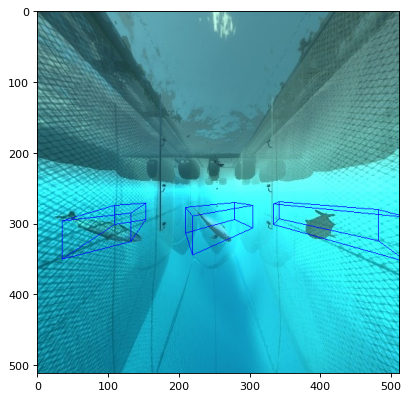

In [10]:
show(cv2.cvtColor(out,cv2.COLOR_BGR2RGB))

In [11]:
ann

,class,trunc,occlusion,alphax,xmin,ymin,xmax,ymax,h,w,l,x,y,z,rx,ry,rz,alphay
0,Car,0,0,8.499753,337,281,448,307,0.236346,0.612282,0.269171,1.0,0.32,0.84,-5.707227,2.443461,-3.01942,10.506882
1,Car,0,0,7.661995,233,279,288,310,0.263605,0.682900,0.300217,-0.0,0.32,0.82,-5.707227,2.443461,-3.01942,10.506882
2,Car,0,0,6.632251,94,282,144,310,0.233860,0.605842,0.266341,-1.0,0.32,0.80,-5.707227,2.443461,-3.01942,10.489429


In [14]:
np.degrees(res['ry'])

143.58124180728106

In [15]:
np.degrees(2.443461)

140.00000270481564

In [36]:
box_2d = {'xmin':x1,'ymin':y1,'xmax':x2,'ymax':y2}
pd.DataFrame([list(box_2d.values())],columns=list(box_2d.keys()))

,xmin,ymin,xmax,ymax
0,168,254,420,359


In [34]:
list(box_2d.values())

[168, 254, 420, 359]

In [35]:
list(box_2d.keys())

['xmin', 'ymin', 'xmax', 'ymax']

In [14]:
sorted(os.listdir(img_dir))

['003000.jpg',
 '003001.jpg',
 '003002.jpg',
 '003003.jpg',
 '003004.jpg',
 '003005.jpg',
 '003006.jpg',
 '003007.jpg',
 '003008.jpg',
 '003009.jpg',
 '003010.jpg',
 '003011.jpg',
 '003012.jpg',
 '003013.jpg',
 '003014.jpg',
 '003015.jpg',
 '003016.jpg',
 '003017.jpg',
 '003018.jpg',
 '003019.jpg',
 '003020.jpg',
 '003021.jpg',
 '003022.jpg',
 '003023.jpg',
 '003024.jpg',
 '003025.jpg',
 '003026.jpg',
 '003027.jpg',
 '003028.jpg',
 '003029.jpg',
 '003030.jpg',
 '003031.jpg',
 '003032.jpg',
 '003033.jpg',
 '003034.jpg',
 '003035.jpg',
 '003036.jpg',
 '003037.jpg',
 '003038.jpg',
 '003039.jpg',
 '003040.jpg',
 '003041.jpg',
 '003042.jpg',
 '003043.jpg',
 '003044.jpg',
 '003045.jpg',
 '003046.jpg',
 '003047.jpg',
 '003048.jpg',
 '003049.jpg',
 '003050.jpg',
 '003051.jpg',
 '003052.jpg',
 '003053.jpg',
 '003054.jpg',
 '003055.jpg',
 '003056.jpg',
 '003057.jpg',
 '003058.jpg',
 '003059.jpg',
 '003060.jpg',
 '003061.jpg',
 '003062.jpg',
 '003063.jpg',
 '003064.jpg',
 '003065.jpg',
 '003066.j